In [218]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt


## Implementation

In [262]:
class ReLU:
    def Forward_prop(self, Z):
      self.Z = Z
      self.A = np.maximum(0,Z)
      return np.maximum(0, Z)

    def Backward_prop(self, dA):
      return dA*(self.A > 0)

class Sigmoid:
    def Forward_prop(self, Z):
        self.A = 1 / (1 + np.exp(-Z))
        return self.A

    def Backward_prop(self, dA):
        return dA * (self.A * (1 - self.A))


class Softmax:
    def Forward_prop(self, Z):
        exp = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)


class Neural_Net:
  def __init__(self,layers_dim,activations):
    # layers_dims: a list of the number of neurones of the corresponding layer (including the number of features of the dataset(as the first value))
    # activations: a list contaning the name of the activation function

    self.L = len(layers_dim) - 1
    self.activations = activations
    self.parameters = {}  # a dictionnary containing the weight and the bias

    for l in range(1, self.L + 1):  #from the first layer to the last one
      self.parameters[f"W{l}"] = (np.random.rand(layers_dim[l-1],layers_dim[l])) * (np.sqrt(2 / layers_dim[l-1])) #the size of the weight matrix of the l-layer is the nb of neurone in the previous layer * the nb of neurone in the current one
      self.parameters[f"b{l}"] = np.zeros((1,layers_dim[l])) #the size of the bias matrix is 1 * the number of neurone in the current layer

  def Forward_prop(self, X):
    self.memory = {"A0": X}
    A = X

    for l in range(1, self.L + 1):  #loop on the number of layer
      W = self.parameters[f"W{l}"]
      b = self.parameters[f"b{l}"]

      #print(f"\n---- Layer {l} ----")
      #print("A shape:", A.shape)
      #print("W shape:", W.shape)
      #print("b shape:", b.shape)


      Z = A @ W + b
      if l < self.L:
      # Hidden layer → activation
        A = self.activations[l-1].Forward_prop(Z)
      else:
      # Output layer → softmax
        A = Softmax().Forward_prop(Z)

      self.memory[f"Z{l}"] = Z
      self.memory[f"A{l}"] = A

    return A

  def Backward_prop(self,X,y,lr):
    n = X.shape[0]
    grads = {}

    A_last =self.memory[f"A{self.L}"]
    dZ = (A_last - compute_y_onehot(y,len(np.unique(y))))/n   #grad of the softmax function
    n_classes = A_last.shape[0]

    for l in reversed(range(1,self.L +1)):  #we compute the gradient backward
        A_prev = self.memory[f"A{l-1}"]
        W = self.parameters[f"W{l}"]

        grads[f"W{l}"] = A_prev.T @ dZ                       #compute and store the grad with respect to W[l]
        grads[f"b{l}"] = np.sum(dZ, axis=0, keepdims=True)   #compute and store the grad with respect to b[l]

        self.parameters[f"W{l}"] -= lr*grads[f"W{l}"]    #Update the weight
        self.parameters[f"b{l}"] -= lr*grads[f"b{l}"]    #Update the bias

        if l > 1:
          dA_prev = dZ @ W.T
          dZ = self.activations[l-2].Backward_prop(dA_prev)  # l-2 and not l-1 because of the gap explain above

  def train(self,X,y,lr,n_iters):
    X = np.array(X)
    y = np.array(y)

    n = len(y)
    losses = []
    y_oh = compute_y_onehot(y,len(np.unique(y)))

    for iter in range(n_iters):
      y_preds = self.Forward_prop(X)     #compute and store all the value in the forward prop
      loss = -np.mean(np.sum(y_oh * np.log(y_preds + 1e-10), axis=1))
      losses.append(loss)
      self.Backward_prop(X,y,lr)
      print(loss)  #update the weight and bias
    return losses
  def predict(self,X):
    X = np.array(X)
    A_last = self.Forward_prop(X)
    return np.argmax(A_last,axis=1)   #return a list containing the class that has the highest prob for every sample



def compute_y_onehot(y,n_classes):             #instead of having the class (0 or 1 or 2) for every row, create a list of list where the class is the index of the 1
  y = np.array(y)
  y_onehot = np.zeros((len(y),n_classes))    #in this sublist (all the other term are set to 0)
  for k in range(len(y)):
    y_onehot[k][y[k]] = 1
  return y_onehot

def split_data(df,target_name): # take the whole df and target's name and return the split data in an adapted form for the gradient_descent function
  df=copy.deepcopy(df)

  train, val, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))]) #split at 0.6 of the df lenght and 0.8 of the df lenght

  df_1=train.drop([target_name],axis=1)
  X_train = df_1.values.tolist()         #list of list of the features for train
  y_train = train[target_name].tolist()   #list of target for train

  df_2=val.drop([target_name],axis=1)
  X_val = df_2.values.tolist()          #list of list of the features for val
  y_val = val[target_name].tolist()    #list of target for val

  df_3=test.drop([target_name],axis=1)
  X_test = df_3.values.tolist()          #list of list of the features for test
  y_test = test[target_name].tolist()    #list of target for test

  return X_train,y_train,X_val,y_val,X_test,y_test

def scale_features(X):    #normalize features
    X = np.array(X)
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    return (X - means) / stds, means, stds  #return the normalized dataset, the mean and the variance to normalize the test set with the same parameters

def accuracy(y,y_preds):
  return np.mean(y == y_preds)


##Data

In [192]:
df_train = pd.read_csv("pendigits.tra",sep=",")
df_train.head()

,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [193]:
X_train = df_train.drop(["class"],axis=1)
#X_train.head()
y_train = df_train["class"]
#y_train.head()
print(len(y_train))

X_train,means,stds = scale_features(X_train)

7494


In [194]:
df_test = pd.read_csv("pendigits.tes",sep=",")
df_test.head()

,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16,class
0,88,92,2,99,16,66,94,37,70,0,0,24,42,65,100,100,8
1,80,100,18,98,60,66,100,29,42,0,0,23,42,61,56,98,8
2,0,94,9,57,20,19,7,0,20,36,70,68,100,100,18,92,8
3,95,82,71,100,27,77,77,73,100,80,93,42,56,13,0,0,9
4,68,100,6,88,47,75,87,82,85,56,100,29,75,6,0,0,9


In [202]:
X_test = df_test.drop(["class"],axis=1)
#X_train.head()
y_test = df_test["class"]
#y_train.head()
X_test = (X_test - means)/stds
X_test.head()


,attribut1,attribut2,attribut3,attribut4,attribut5,attribut6,attribut7,attribut8,attribut9,attribut10,attribut11,attribut12,attribut13,attribut14,attribut15,attribut16
0,1.519087,0.434530,-1.447597,0.820404,-0.998667,0.034906,1.386274,-0.247890,0.382148,-1.240765,-1.654194,-0.428533,-0.561979,0.878928,1.280702,1.994895
1,1.278990,0.909384,-0.838172,0.769480,0.261181,0.034906,1.581854,-0.508838,-0.449253,-1.240765,-1.654194,-0.464905,-0.561979,0.758524,0.221202,1.939043
2,-1.121985,0.553243,-1.180974,-1.318386,-0.884135,-1.681957,-1.449632,-1.454775,-1.102496,0.070321,0.231161,1.171816,2.004589,1.932466,-0.693821,1.771486
3,1.729173,-0.159037,1.180547,0.871327,-0.683705,0.436725,0.832132,0.926376,1.272935,1.672759,0.850634,0.226155,0.057537,-0.686328,-1.127253,-0.797722
4,0.918844,0.909384,-1.295241,0.260244,-0.111047,0.363667,1.158098,1.219943,0.827542,0.798702,1.039170,-0.246675,0.898309,-0.897036,-1.127253,-0.797722


In [196]:
X_train,X_test,y_train,y_test = np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test),

##Result

In [197]:
print(X_train.shape)
print(len(X_train), len(y_train))


(7494, 16)
7494 7494


In [292]:
layers_dim = [16, 32, 16, len(np.unique(y_train))]
#print(np.unique(y_train))
activations = [ReLU(),ReLU()]
model = Neural_Net(layers_dim,activations)
losses = model.train(X_train,y_train,0.05,3500)
#print(losses)

2.3406638672159885
2.2739103283684097
2.245506185306943
2.2283760457932997
2.216238923696859
2.2069831942498537
2.19955379569955
2.1933481521761626
2.1880037486587978
2.1832888494174316
2.1790483354338357
2.175173729216217
2.1715862912254607
2.168227589518968
2.165053411851353
2.1620309641070397
2.159134463800311
2.1563423638994217
2.1536407356077825
2.151015991888783
2.1484570074876266
2.14595557915273
2.1435032672026733
2.1410941308579563
2.1387237578597187
2.1363882067034723
2.1340825355645556
2.1318013038074737
2.1295437749144592
2.127306296553064
2.1250862089057363
2.1228827264853396
2.12069360150435
2.118517639594982
2.1163523604365504
2.114194262600489
2.112045084199013
2.1099010112787795
2.1077631631413913
2.1056289039226472
2.103497908026388
2.1013711084677063
2.0992454602422113
2.097122339761537
2.094996973685211
2.0928715400655813
2.0907441914023503
2.0886141890553502
2.086481648812389
2.084345023936924
2.0822056454587736
2.0800599412365925
2.0779098746692486
2.0757518264374

[np.float64(0.04437504834095346), np.float64(0.04438708965374742), np.float64(0.044399138862510366), np.float64(0.04441119555206863), np.float64(0.04442326404785102), np.float64(0.04443532913919236), np.float64(0.04444740839111114), np.float64(0.04445949270591711), np.float64(0.04447158661067106), np.float64(0.044483683068873604), np.float64(0.04449577775592726), np.float64(0.044507887177075996), np.float64(0.04452000609303387), np.float64(0.044532131601282755), np.float64(0.04454425656750616), np.float64(0.04455639148256927), np.float64(0.044568542979939736), np.float64(0.04458070220378488), np.float64(0.04459286599761163), np.float64(0.04460502618088241), np.float64(0.04461720470591269), np.float64(0.044629389391726226), np.float64(0.04464158351297795), np.float64(0.04465377939481968), np.float64(0.04466598695265761), np.float64(0.044678207479926624), np.float64(0.04469043145809645), np.float64(0.044702667713506755), np.float64(0.04471490062846875), np.float64(0.04472714988059169), n

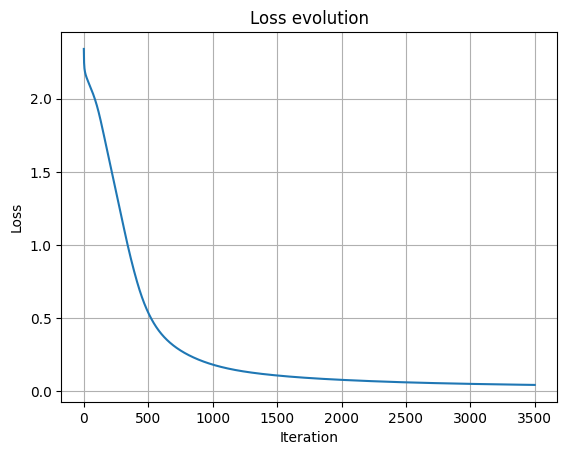

In [293]:
losses_1 = losses[::-1]
print(losses_1)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.grid(True)
plt.show()

In [294]:
y_preds = model.predict(X_test)
acc = np.mean(y_preds == y_test)
print("Test accuracy:", acc)
losses[:10]

Test accuracy: 0.9576901086335049


[np.float64(2.3406638672159885),
 np.float64(2.2739103283684097),
 np.float64(2.245506185306943),
 np.float64(2.2283760457932997),
 np.float64(2.216238923696859),
 np.float64(2.2069831942498537),
 np.float64(2.19955379569955),
 np.float64(2.1933481521761626),
 np.float64(2.1880037486587978),
 np.float64(2.1832888494174316)]

In [288]:
layers_dim = [16, 32, 32, len(np.unique(y_train))]
#print(np.unique(y_train))
activations = [ReLU(),ReLU()]
model = Neural_Net(layers_dim,activations)
losses = model.train(X_train,y_train,0.05,3500)
#print(losses)

2.504514673079818
2.2545272955930082
2.2093254321823568
2.1888781954481815
2.1779684961830683
2.1704233888825795
2.1645629260929082
2.159691906230151
2.1554388672709353
2.151587998386367
2.148009924641374
2.1446313082481776
2.1413959281479054
2.1382714820988826
2.1352338909612043
2.1322623853188563
2.129347271621402
2.1264742537062755
2.123638306640241
2.1208312194066523
2.1180470016411075
2.115282967468765
2.1125296078420406
2.1097928265362227
2.1070585267569273
2.1043339167079873
2.101609550046225
2.0988880832559045
2.0961659389584777
2.093443556324551
2.0907127441760274
2.087981407386748
2.0852370634559327
2.082487410862773
2.079726245469851
2.0769527140311252
2.0741677125026277
2.0713691104481877
2.0685529785845667
2.065721407141079
2.0628736588120784
2.060003381740063
2.057118028702495
2.054206909766782
2.0512770690092648
2.048323264363321
2.045346067682343
2.0423410253333363
2.0393122457738118
2.036253546993772
2.033165361803231
2.0300518054413947
2.026901132645852
2.023723901202

[np.float64(0.04157839320474538), np.float64(0.04158953004256884), np.float64(0.04160065523462718), np.float64(0.04161179154108368), np.float64(0.04162294254422834), np.float64(0.041634085879554764), np.float64(0.0416452581929096), np.float64(0.041656419658794575), np.float64(0.0416676140700383), np.float64(0.04167880162715324), np.float64(0.04169000108920237), np.float64(0.0417012270647161), np.float64(0.04171243106162558), np.float64(0.041723670790446116), np.float64(0.041734892577872974), np.float64(0.041746153008143896), np.float64(0.041757400798994475), np.float64(0.04176866925110245), np.float64(0.04177993338402661), np.float64(0.041791206054070745), np.float64(0.041802489257252315), np.float64(0.04181377028153286), np.float64(0.04182507034830843), np.float64(0.04183636557308791), np.float64(0.04184767829235706), np.float64(0.041858990380361276), np.float64(0.04187032940855993), np.float64(0.04188164638171316), np.float64(0.04189300114656966), np.float64(0.041904335224810164), np

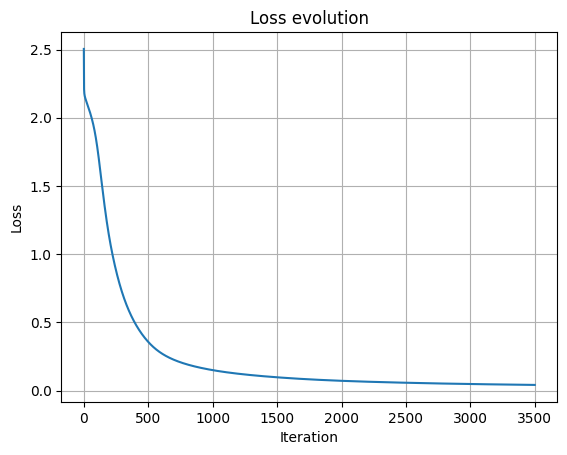

In [289]:
losses_1 = losses[::-1]
print(losses_1)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.grid(True)
plt.show()

In [290]:
y_preds = model.predict(X_test)
acc = np.mean(y_preds == y_test)
print("Test accuracy:", acc)
losses[:10]

Test accuracy: 0.9585477415666095


[np.float64(2.504514673079818),
 np.float64(2.2545272955930082),
 np.float64(2.2093254321823568),
 np.float64(2.1888781954481815),
 np.float64(2.1779684961830683),
 np.float64(2.1704233888825795),
 np.float64(2.1645629260929082),
 np.float64(2.159691906230151),
 np.float64(2.1554388672709353),
 np.float64(2.151587998386367)]